In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2025-08-22 18:51:15.523356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755868875.628472    6943 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755868875.656220    6943 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755868875.850757    6943 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755868875.850799    6943 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755868875.850802    6943 computation_placer.cc:177] computation placer alr

In [ ]:

# Your exact code with ONLY parameter changes for professional results
!mkdir save_here4
model = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(400, 400, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

model.trainable = False
submodel = tf.keras.Model(inputs=model.input , outputs = model.get_layer("block1_conv1").output)
submodel1 = tf.keras.Model(inputs=model.input , outputs = model.get_layer("block2_conv1").output)
submodel2 = tf.keras.Model(inputs=model.input , outputs = model.get_layer("block3_conv1").output)
submodel3 = tf.keras.Model(inputs=model.input , outputs = model.get_layer("block4_conv1").output)
submodel4 = tf.keras.Model(inputs=model.input , outputs = model.get_layer("block5_conv1").output)
submodeldeep = tf.keras.Model(inputs=model.input , outputs = model.get_layer("block5_conv4").output)

def gram_matrices_vectorized(a_a):  # Fixed typo: grahm -> gram
    b , i , j , k =  a_a.shape[0] , a_a.shape[1] , a_a.shape[2] , a_a.shape[3]  
    grahm_matrix = tf.zeros([b,k,k])
    X = tf.reshape(a_a , (b,i*j,k))    
    grahm_matrix= tf.matmul(X,X,transpose_a = True)
    return grahm_matrix

def style_cost(G_s, G_g, a_s):
    batch_size, n_h, n_w, n_c = a_s.shape[0], a_s.shape[1], a_s.shape[2], a_s.shape[3]
    
    sub = tf.reduce_sum(tf.square(tf.subtract(G_s, G_g)))
    norm = 4.0 * tf.cast(n_h * n_w, tf.float32) * tf.cast(n_c * n_c, tf.float32)
    
    result = tf.divide(sub, norm)
    return result

def content_cost(a_c, a_g_c):
    cost = 0.5 * tf.reduce_mean(tf.square(a_c - a_g_c))
    return cost

# ADD: Total variation loss to reduce high-frequency artifacts/pixelation
def total_variation_loss(img):
    x_deltas = img[:, :, 1:, :] - img[:, :, :-1, :]
    y_deltas = img[:, 1:, :, :] - img[:, :-1, :, :]
    return tf.reduce_mean(tf.abs(x_deltas)) + tf.reduce_mean(tf.abs(y_deltas))

def total_loss(a_c, a_s, a_g_s, a_g_c, alpha=0.1, beta=0.1):
    G_s = gram_matrices_vectorized(a_s)  # Fixed function name call
    G_g = gram_matrices_vectorized(a_g_s)  # Fixed function name call
    style = style_cost(G_s, G_g, a_s)
    content = content_cost(a_c, a_g_c)
    total_cost = alpha * content + beta * style
    return total_cost

dim = 400
img1 = tf.keras.utils.load_img("images/monet.jpg" , target_size = (dim,dim))
img2 = tf.keras.utils.load_img("images/louvre.jpg" , target_size = (dim,dim))
img1 = tf.expand_dims(img1,axis = 0)
img1 = tf.constant(img1)
styleImg = tf.keras.applications.vgg19.preprocess_input(img1)
img2 = tf.expand_dims(img2,axis = 0)
img2 = tf.constant(img2)
contentImg = tf.keras.applications.vgg19.preprocess_input(img2)
# generatedImg = tf.Variable(tf.random.normal(styleImg.shape),trainable = True)
generatedImg = tf.Variable(tf.cast(img2, tf.float32), trainable=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)  # CHANGED: More conservative start

for i in range(20001):  # CHANGED: Start from 0 for clean run
    with tf.GradientTape() as tape:

        a_c = submodeldeep(contentImg)
        a_g_c = submodeldeep(generatedImg)
        a_s = submodel(styleImg)
        a_s_1 = submodel1(styleImg)
        a_s_2 = submodel2(styleImg)
        a_s_3 = submodel3(styleImg)
        a_s_4 = submodel4(styleImg)
        a_g_s = submodel(generatedImg)
        a_g_s_1 = submodel1(generatedImg)
        a_g_s_2 = submodel2(generatedImg)
        a_g_s_3 = submodel3(generatedImg)
        a_g_s_4 = submodel4(generatedImg)
        
        # CHANGED: Professional layer weighting - more balanced
        loss1 = total_loss(a_c, a_s, a_g_s, a_g_c, alpha=0.08, beta=0.25)     
        loss2 = total_loss(a_c, a_s_1, a_g_s_1, a_g_c, alpha=0.08, beta=0.20)   
        loss3 = total_loss(a_c, a_s_2, a_g_s_2, a_g_c, alpha=0.08, beta=0.15)    
        loss4 = total_loss(a_c, a_s_3, a_g_s_3, a_g_c, alpha=0.08, beta=0.08)   
        loss5 = total_loss(a_c, a_s_4, a_g_s_4, a_g_c, alpha=0.08, beta=0.06)
        
        # CHANGED: Higher TV loss for smoother results
        tv_loss = total_variation_loss(generatedImg) * 5e-4  
        
        loss = loss1 + loss2 + loss3 + loss4 + loss5 + tv_loss
        
        grads = tape.gradient(loss, generatedImg)
        # CHANGED: Less aggressive gradient processing for stability
        grads = grads / (tf.norm(grads) + 1e-8)  
        grads = tf.clip_by_value(grads, -0.5, 0.5)  # CHANGED: Less restrictive clipping
        
        optimizer.apply_gradients([(grads, generatedImg)])
        generatedImg.assign(tf.clip_by_value(generatedImg, -127.5, 127.5))
        
        # CHANGED: More gradual learning rate decay
        if i == 2500:  
            optimizer.learning_rate = 0.003
        elif i == 6000:
            optimizer.learning_rate = 0.001
        elif i == 12000:
            optimizer.learning_rate = 0.0005
        elif i == 16000:
            optimizer.learning_rate = 0.0002
            
        if i%100 == 0:
            print(loss.numpy())
            display_img = generatedImg[0].numpy()
            display_img = display_img + [103.939, 116.779, 123.68]
            display_img = display_img[..., ::-1]
            display_img = np.clip(display_img, 0, 255).astype(np.uint8)
            plt.figure(figsize = (20,2))
            plt.imshow(display_img)
            plt.show()
            tf.keras.utils.save_img(
                f'./save_here4/image{i}.jpeg', generatedImg[0], file_format='jpeg', scale=True,
            )
            
            # Calculate individual losses for monitoring
            G_s = gram_matrices_vectorized(a_s)
            G_g = gram_matrices_vectorized(a_g_s)
            style_loss = style_cost(G_s, G_g, a_s)
            content_loss = content_cost(a_c, a_g_c)
            
            print(f"Iteration {i}:")
            print(f"  Content loss: {content_loss.numpy():.2e}")
            print(f"  Style loss: {style_loss.numpy():.2e}")
            print(f"  TV loss: {tv_loss.numpy():.2e}")
            print(f"  Total loss: {loss.numpy():.2e}")
            print(f"  Generated img range: [{tf.reduce_min(generatedImg).numpy():.2f}, {tf.reduce_max(generatedImg).numpy():.2f}]")

generatedCheckpoint = tf.Variable(generatedImg)

tf.keras.utils.save_img(
    f'./save_here4/image{i}.jpeg', generatedImg[0], file_format='jpeg', scale=True,
)

display_img = generatedImg[0].numpy()
display_img = display_img + [103.939, 116.779, 123.68]
display_img = display_img[..., ::-1]
display_img = np.clip(display_img, 0, 255).astype(np.uint8)
plt.imshow(display_img)

In [3]:
model = tf.keras.applications.VGG19(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)
model.layers

I0000 00:00:1755868892.525400    6943 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4149 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-08-22 18:51:37.427478: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


[<InputLayer name=input_layer, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <Conv2D name=block3_conv4, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <Conv2D name=block4_conv4, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <Conv2D name=block5_conv4, built=True>,
 <MaxPooling2D name=block5_pool, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=fc1, built=True>,
 <

In [4]:
# def style_loss(a_s,a_g):
#     G_s = np.zeros((a_s.shape[1],a_g.shape[1],3)) 

In [5]:
from tensorflow.keras.utils import load_img
img = load_img('test.png',target_size = (224,224))

In [6]:
img = tf.expand_dims(img,axis = 0)
img = tf.constant(img)
img = tf.keras.applications.vgg19.preprocess_input(img)
img

<tf.Tensor: shape=(1, 224, 224, 3), dtype=uint8, numpy=
array([[[[152, 139, 132],
         [152, 139, 132],
         [152, 139, 132],
         ...,
         [158, 145, 138],
         [152, 139, 132],
         [152, 139, 132]],

        [[152, 139, 132],
         [152, 139, 132],
         [152, 139, 132],
         ...,
         [152, 139, 132],
         [152, 139, 132],
         [152, 139, 132]],

        [[152, 139, 132],
         [152, 139, 132],
         [152, 139, 132],
         ...,
         [152, 139, 132],
         [152, 139, 132],
         [152, 139, 132]],

        ...,

        [[152, 139, 132],
         [152, 139, 132],
         [152, 139, 132],
         ...,
         [152, 139, 132],
         [152, 139, 132],
         [152, 139, 132]],

        [[152, 139, 132],
         [152, 139, 132],
         [152, 139, 132],
         ...,
         [152, 139, 132],
         [152, 139, 132],
         [152, 139, 132]],

        [[152, 139, 132],
         [152, 139, 132],
         [152, 139

In [7]:
np.argmax(tf.keras.layers.Activation('softmax')(model(img)))

I0000 00:00:1755868899.237983    6943 cuda_dnn.cc:529] Loaded cuDNN version 90300


526

In [8]:
from tensorflow.keras.applications.vgg19 import decode_predictions, VGG19, preprocess_input
import numpy as np

preds = model.predict(img)  
decoded = decode_predictions(preds, top=5)[0] 
for _, class_name, score in decoded:
    print(class_name, score)

I0000 00:00:1755868901.009447    9069 service.cc:152] XLA service 0x79582800bd90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755868901.009492    9069 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-08-22 18:51:41.032834: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-22 18:51:43.010465: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 184 bytes spill stores, 184 bytes spill loads

2025-08-22 18:51:44.208254: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 4808 bytes spill stores, 4800 bytes spill loads

2025-08-22 18:51:44.3539

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
desk 0.42602867
binder 0.09272699
scale 0.043527193
balance_beam 0.030414375
parallel_bars 0.023884008


I0000 00:00:1755868905.697169    9069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [9]:
submodel = tf.keras.Model(inputs=model.input , outputs = model.get_layer("block2_conv2").output)
submodeldeep = tf.keras.Model(inputs=model.input , outputs = model.get_layer("block4_conv3").output)

In [10]:
pred = submodel(img)
pred_np = pred[0].numpy()
actmax = np.max(pred[0])
maxi, maxy, maxj = np.unravel_index(np.argmax(pred_np), pred_np.shape)
print(maxi,maxy,maxj)
# plt.imshow(pred.numpy()[0,i,y,j])
# submodel(img)

99 49 45


In [11]:
predDeep = submodeldeep(img)
pred_np_deep = predDeep[0].numpy()
actmax = np.max(predDeep[0])
maxi_deep, maxy_deep, maxj_deep = np.unravel_index(np.argmax(pred_np_deep), pred_np_deep.shape)
print(maxi_deep,maxy_deep,maxj_deep,pred_np_deep.shape)
# plt.imshow(pred.numpy()[0,i,y,j])
# submodel(img)

10 14 46 (28, 28, 512)


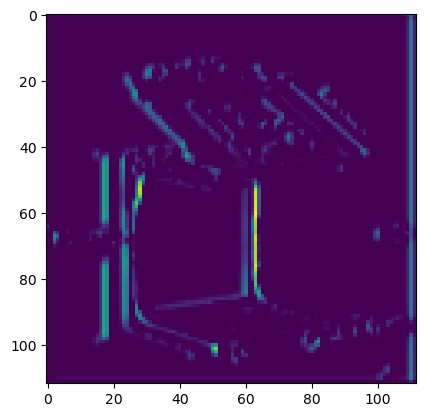

In [12]:
plt.imshow(pred.numpy()[0,:,:,1])

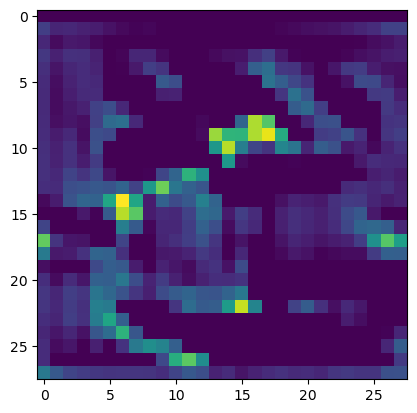

In [13]:
plt.imshow(predDeep.numpy()[0,:,:,1])

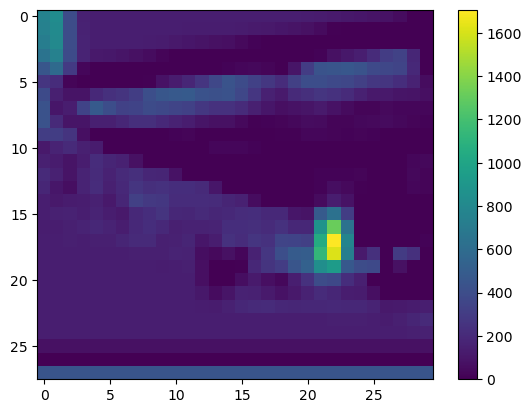

In [14]:
x_center, y_center = 99, 45  # example coordinates
patch_size = 50  # size of the square crop (e.g., 32x32)

# Calculate the cropping boundaries, making sure you don't go out of image bounds
x_start = max(x_center - patch_size // 2, 0)
x_end = min(x_center + patch_size // 2, img.shape[0])
y_start = max(y_center - patch_size // 2, 0)
y_end = min(y_center + patch_size // 2, img.shape[1])

# Crop the patch from the input image
patch = pred_np[x_center-15:x_center+15, y_center-15:y_center+15, 90]

# Display the patch
plt.imshow(patch, cmap='viridis')
plt.colorbar()
plt.show()



In [15]:
img1 = load_img("style.jpg" , target_size = (224,224))
img2 = load_img("content.jpg" , target_size = (224,224))
img1 = tf.expand_dims(img1,axis = 0)
img1 = tf.constant(img1)
styleImg = tf.keras.applications.vgg19.preprocess_input(img)
img2 = tf.expand_dims(img2,axis = 0)
img2 = tf.constant(img2)
contentImg = tf.keras.applications.vgg19.preprocess_input(img)

In [16]:
generatedImg = tf.constant(tf.zeros(styleImg.shape))

In [17]:
print(generatedImg.shape)
print(styleImg.shape)
print(contentImg.shape)    

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [18]:
a_s = submodeldeep(styleImg)
a_g = submodeldeep(generatedImg)
a_c = submodeldeep(contentImg)
a_s.shape

TensorShape([1, 28, 28, 512])

In [19]:
# def grahm_matrices(a_s,a_g):
#     i , j , k = a_s.shape[1] , a_s.shape[2] , a_s.shape[3]    
#     grahm_matrix_as = np.zeros((k,k))
#     grahm_matrix_ag = np.zeros((k,k))
#     for channel in range(k):
#         for channel2 in range(k):
#             grahm_matrix_as[channel,channel2] =  np.sum(a_s[:,:,:,channel]*a_s[:,:,:,channel2])
#             grahm_matrix_ag[channel,channel2] =  np.sum(a_g[:,:,:,channel]*a_g[:,:,:,channel2])
#     grahm_matrix_as = tf.constant(grahm_matrix_as,dtype = tf.float32)    
#     grahm_matrix_ag = tf.constant(grahm_matrix_ag,dtype = tf.float32)                                                                      
#     return grahm_matrix_as , grahm_matrix_ag
# grahm_matrix_as , grahm_matrix_ag = grahm_matrices(a_s,a_g)

In [20]:
def grahm_matrices_vectorized(a_a):
    b , i , j , k =  a_a.shape[0] , a_a.shape[1] , a_a.shape[2] , a_a.shape[3]    
    grahm_matrix = tf.zeros([b,k,k])
    X = tf.reshape(a_a , (b,i*j,k))    
    grahm_matrix= tf.matmul(X,X,transpose_a = True)
    return grahm_matrix
grahm_matrix_as_vec  = grahm_matrices_vectorized(a_s)
grahm_matrix_ag_vec = grahm_matrices_vectorized(a_g)

In [167]:
def style_cost(G_s,G_g,a_s):
    batch_size , n_h,n_w,n_c = a_s.shape[0],a_s.shape[1],a_s.shape[2],a_s.shape[3]
    sub = tf.reduce_sum(tf.square(tf.subtract(G_s,G_g)))
    norm = 4.0 * tf.cast(n_h * n_w * n_c, tf.float32) * tf.cast(n_h * n_w * n_c, tf.float32)
    result = tf.divide(sub,norm)
    return result
def content_cost(a_c, a_g):
    cost = 0.5 * tf.reduce_sum(tf.square(a_c - a_g))
    return cost
def total_loss(a_c, a_s, a_g, alpha=1, beta=0.001):
    G_s = grahm_matrices_vectorized(a_s)
    G_g = grahm_matrices_vectorized(a_g)
    style = style_cost(G_s, G_g,a_s)
    content = content_cost(a_c, a_g)
    total_cost = alpha * content + beta * style
    return total_cost

In [168]:
img1 = load_img("style.jpg" , target_size = (224,224))
img2 = load_img("content.jpg" , target_size = (224,224))
img1 = tf.expand_dims(img1,axis = 0)
img1 = tf.constant(img1)
styleImg = tf.keras.applications.vgg19.preprocess_input(img1)
img2 = tf.expand_dims(img2,axis = 0)
img2 = tf.constant(img2)
contentImg = tf.keras.applications.vgg19.preprocess_input(img2)
# generatedImg = tf.Variable(tf.random.normal(styleImg.shape),trainable = True)
generatedImg = tf.Variable(tf.cast(img2, tf.float32), trainable=True)

136279580000.0


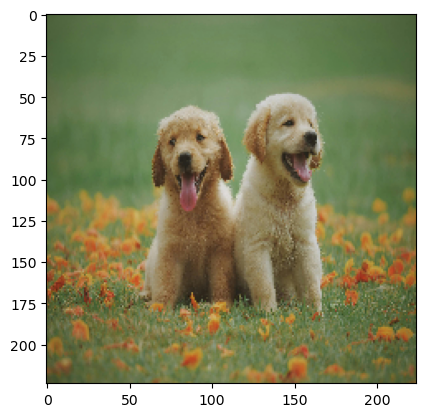

124293800000.0


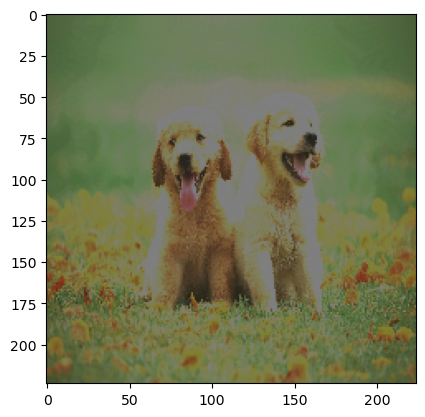

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for i in range(20000):
    with tf.GradientTape() as tape:
        a_c = submodeldeep(contentImg)
        a_s = submodeldeep(styleImg)
        a_g = submodeldeep(generatedImg)
        loss = total_loss(a_c,a_s,a_g)
        if i%100 == 0:
            print(loss.numpy())
            plt.imshow(generatedImg[0]/255)
            plt.show()
            tf.keras.utils.save_img(
                './save_here', generatedImg[0], file_format='jpeg', scale=True,
            )
            # G_s = grahm_matrices_vectorized(a_s)
            # G_g = grahm_matrices_vectorized(a_g)
            # style_loss = style_cost(G_s, G_g, a_s)
            # content_loss = content_cost(a_c, a_g)
            
            # print(f"Iteration {i}:")
            # print(f"  Content loss: {content_loss.numpy():.2e}")
            # print(f"  Style loss: {style_loss.numpy():.2e}")
            # print(f"  Total loss: {loss.numpy():.2e}")
            # print(f"  Generated img range: [{tf.reduce_min(generatedImg).numpy():.2f}, {tf.reduce_max(generatedImg).numpy():.2f}]")
        grads = tape.gradient(loss,generatedImg)
        grads = tf.clip_by_value(grads, -1., 1.)  
        optimizer.apply_gradients([(grads, generatedImg)])
        generatedImg.assign(tf.clip_by_value(generatedImg, -127.5, 127.5))  

In [130]:
generatedCheckpoint = tf.Variable(generatedImg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..0.5].


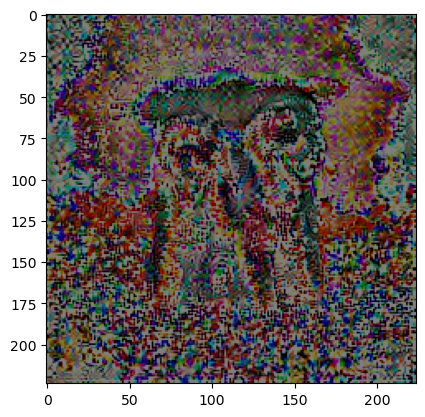

In [158]:
plt.imshow(generatedImg[0,:,:,:]/255)